# Corona Tweets Classification using Keras:

In [128]:
pip install plotly

  Using cached plotly-4.10.0-py2.py3-none-any.whl (13.0 MB)
Processing /Users/spavot/Library/Caches/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf/retrying-1.3.3-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


## Package & Libraries:

In [64]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import tensorflow as tf
from nltk.corpus import stopwords
nltk.download('stopwords')
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Flatten, GlobalMaxPool1D, Conv1D
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.model_selection import RandomizedSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/spavot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data reading

In [65]:
train = pd.read_csv('/Users/spavot/Documents/Perso/Text classification & Visualization/Data/Corona_NLP_train.csv', encoding = 'latin')
test = pd.read_csv('/Users/spavot/Documents/Perso/Text classification & Visualization/Data/Corona_NLP_test.csv', encoding ='latin')

## Data exploration:

In [66]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


In [67]:
#Replace Extremely Positive & Negative with Positive and Negative
train.loc[train.Sentiment == 'Extremely Negative','Sentiment'] = 'Negative'
train.loc[train.Sentiment == 'Extremely Positive', 'Sentiment'] = 'Positive'

test.loc[test.Sentiment == 'Extremely Negative', 'Sentiment'] = 'Negative'
test.loc[test.Sentiment == 'Extremely Positive', 'Sentiment'] = 'Positive'

* We see that we have 41157 values but we have only 32k non null values for location, we will have to fix this:

* UserName and ScreenName are id related data, we won't use it


Let's see which location is the more popular:

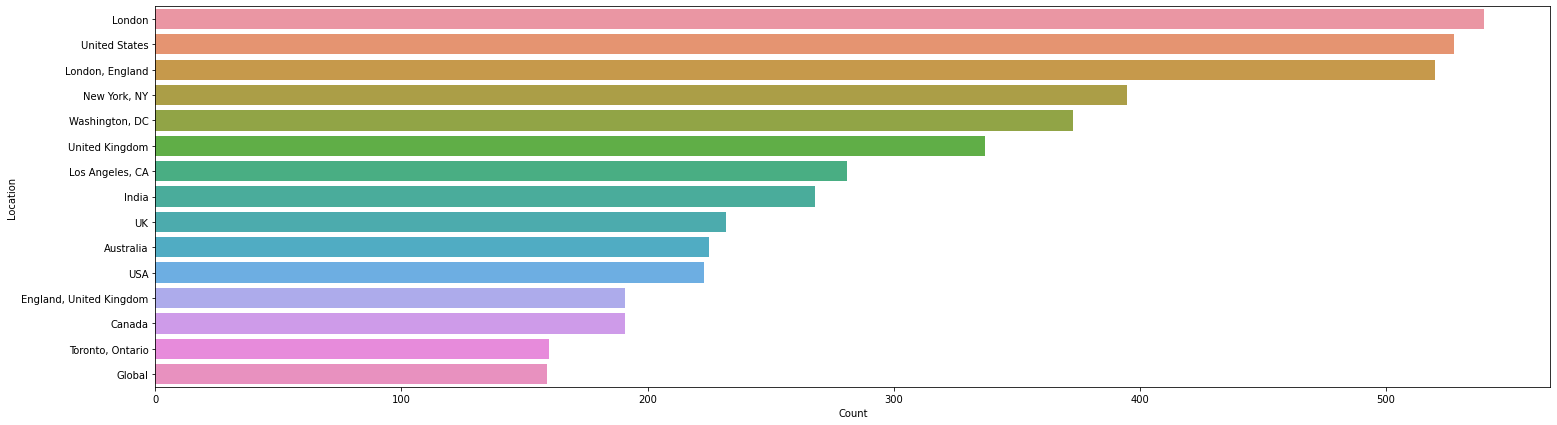

In [68]:
location = train.Location
location = pd.DataFrame(location)
location['Count'] = 1
location = location.groupby('Location').sum().sort_values(by = 'Count', ascending = False).nlargest(15,['Count'])
location = location.reset_index()
plt.figure(figsize=(25,7))
sns.barplot(x = 'Count', y = 'Location', data = location)
plt.show()

We can see that we have some noises and some location are country where other are cities

Now we want to have a look of the distribution of our target variable:

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

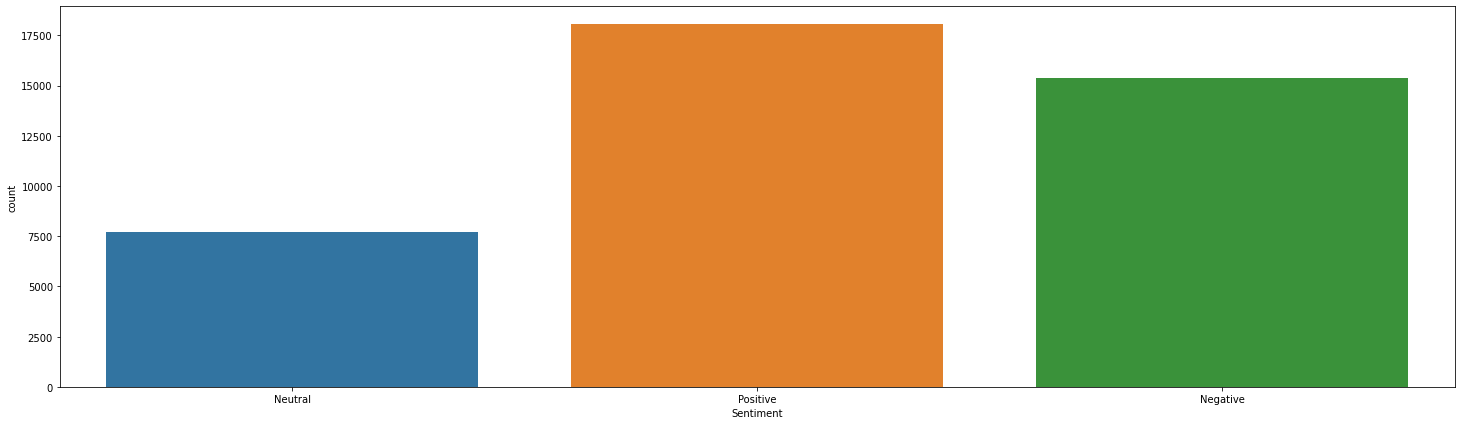

In [69]:
plt.figure(figsize=(25,7))
sns.countplot(train.Sentiment)

Seems like the target variable distribution is not skewed and we doesn't risk to have a category which is never predicted due to the lack of presence.

Let's look at the distribution of tweets over time:

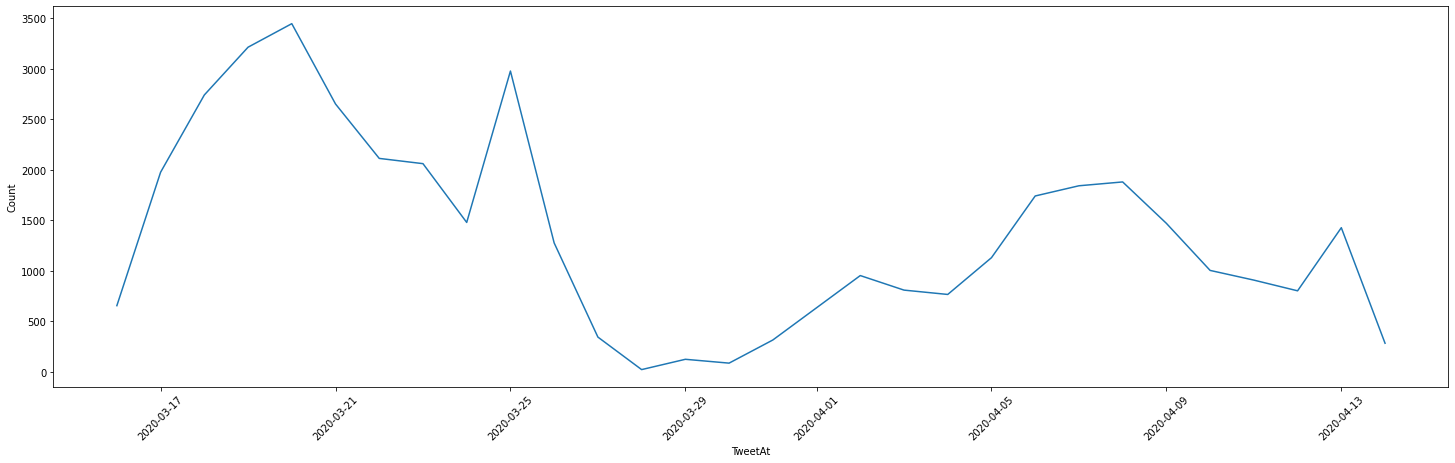

In [70]:
time = train.TweetAt
time = pd.DataFrame(time)
time['Count'] = 1
time = time.groupby('TweetAt').sum()
time = time.reset_index()
time = time.iloc[1:,:]
time['TweetAt'] = pd.to_datetime(time['TweetAt'], format = '%d-%m-%Y')
plt.figure(figsize=(25,7))
sns.lineplot(x = 'TweetAt', y = 'Count', data = time)
plt.xticks(rotation=45)
plt.show()

In [71]:
Min = time.TweetAt.min()
Max = time.TweetAt.max()
print(f'The date range of the data is between {Min} and {Max}')

The date range of the data is between 2020-03-16 00:00:00 and 2020-04-14 00:00:00


Seems like we have some day without data and some with a lot of tweets. The tweets are spread between 16 of March to 14 of April

Finally, let's analyze the lengths of tweets:

<AxesSubplot:ylabel='Density'>

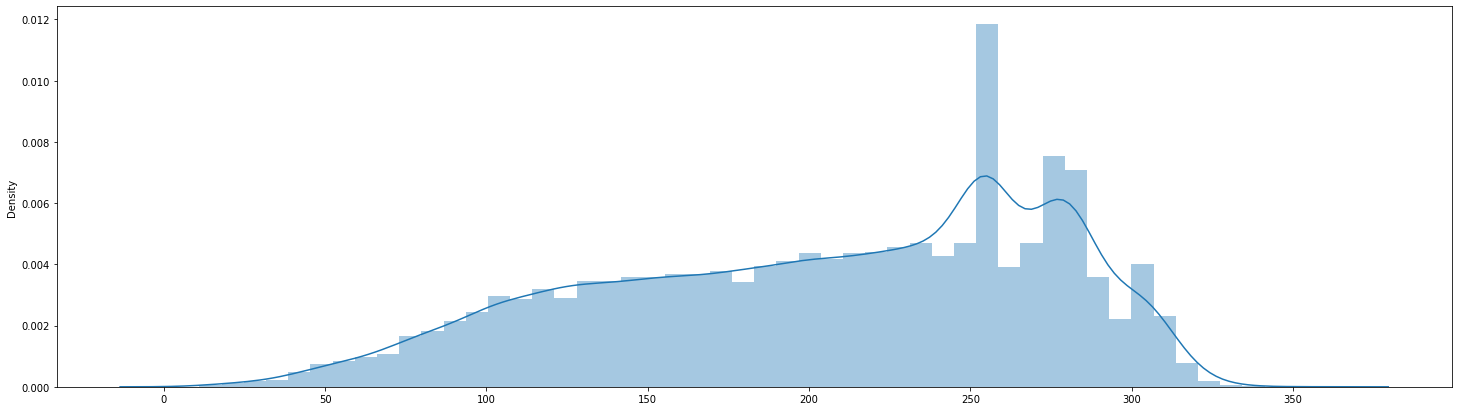

In [72]:
length_tweets = pd.DataFrame(train.OriginalTweet)
length_measured = []
for i in length_tweets.OriginalTweet:
 length_measured.append(len(i))

plt.figure(figsize=(25,7))
sns.distplot(length_measured)

It seems that the repartition is pretty well distributed, we can see a raise at 260 characters but overall we have tweets of all size. Note that we will have to check the length after processing the tweets

## Data cleaning:

### Drop variables

Let's first drop UserName and ScreenName as they are only id variables so we won't use them:

In [73]:
train = train.drop(['UserName','ScreenName'], axis = 1)
test = test.drop(['UserName','ScreenName'], axis = 1)

### Location variable

First, we will replace "NA" values with "Unknown"

In [74]:
train.Location = train.Location.fillna('Unknown')

Now we import a dataframe containg major cities in the word and countries in order join on it:

In [75]:
city_country = pd.read_csv('/Users/spavot/Documents/Perso/Text classification & Visualization/Data/world-cities.csv')

In [76]:
city_list = []

# for i in train.Location:
#     for y in city_country.name:
#         if y.lower() in i.lower():
#             city_name = y
#         else:
#             city_name = 'Unknown'
#     city_list.append(city_name)

In [77]:
# city_list = pd.DataFrame(city_list)
# city_list.value_counts()

We transform the TweetAt column into time variable:

### TweetAt Variable

In [78]:
train['TweetAt'] = pd.to_datetime(train['TweetAt'], format = '%d-%m-%Y')
test['TweetAt'] = pd.to_datetime(test['TweetAt'], format = '%d-%m-%Y')

### Original tweet cleaning

Now we will start fixing the tweets, we need to remove the punctuation and specific characters etc.. 

In [79]:
train.OriginalTweet.head(10)

0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
3    My food stock is not the only one which is emp...
4    Me, ready to go at supermarket during the #COV...
5    As news of the regionÂs first confirmed COVID...
6    Cashier at grocery store was sharing his insig...
7    Was at the supermarket today. Didn't buy toile...
8    Due to COVID-19 our retail store and classroom...
9    For corona prevention,we should stop to buy th...
Name: OriginalTweet, dtype: object

In [80]:
#Transform to lower:
train.OriginalTweet = train.OriginalTweet.str.lower()
test.OriginalTweet = test.OriginalTweet.str.lower()

In [81]:
#Remove urls:
train.OriginalTweet = train.OriginalTweet.str.replace('http\S+|www.\S+', '', case=False)
test.OriginalTweet = test.OriginalTweet.str.replace('http\S+|www.\S+', '', case=False)

In [82]:
train.OriginalTweet = train.OriginalTweet.str.replace('#', '', case=False)
test.OriginalTweet = test.OriginalTweet.str.replace('#', '', case=False)


In [83]:
train.head()

,Location,TweetAt,OriginalTweet,Sentiment
0,London,2020-03-16,@menyrbie @phil_gahan @chrisitv and and,Neutral
1,UK,2020-03-16,advice talk to your neighbours family to excha...,Positive
2,Vagabonds,2020-03-16,coronavirus australia: woolworths to give elde...,Positive
3,Unknown,2020-03-16,my food stock is not the only one which is emp...,Positive
4,Unknown,2020-03-16,"me, ready to go at supermarket during the covi...",Negative


In [84]:
# #Replace hashtags text now that we extracted it
# train.OriginalTweet = train.OriginalTweet.apply(lambda x: ' '.join([word for word in x.split() if word[0] != '#']))
# test.OriginalTweet = test.OriginalTweet.apply(lambda x: ' '.join([word for word in x.split() if word[0] != '#']))

In [85]:
#Remove punctuation, special characters & mentions:
train.OriginalTweet = train.OriginalTweet.str.replace(r'[^\w\s]', '', case=False)
test.OriginalTweet = test.OriginalTweet.str.replace(r'[^\w\s]', '', case=False)

In [86]:
# #Remove stopwords:
stop_words = set(stopwords.words('english'))
train.OriginalTweet = train.OriginalTweet.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test.OriginalTweet = test.OriginalTweet.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

In [87]:
#Remove non alphabetic words:
train.OriginalTweet = train.OriginalTweet.apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))
test.OriginalTweet = test.OriginalTweet.apply(lambda x: ' '.join([word for word in x.split() if word.isalpha()]))

In [88]:
#Remove emptys rows:
train = train[train.OriginalTweet != '']
test = test[test.OriginalTweet != '']

In [89]:
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
train.OriginalTweet = train.OriginalTweet.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
test.OriginalTweet = test.OriginalTweet.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

[nltk_data] Downloading package wordnet to /Users/spavot/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Let's check if the cleaning seems okay:

In [90]:
for i in range(0,5):
    print(i,':',train.OriginalTweet[i])
    print(i,':',test.OriginalTweet[i])

0 : menyrbie chrisitv
0 : trending new yorkers encounter empty supermarket shelf pictured wegmans brooklyn soldout online grocer foodkick maxdelivery coronavirusfearing shopper stock
1 : advice talk neighbour family exchange phone number create contact list phone number neighbour school employer chemist gp set online shopping account po adequate supply regular med order
1 : couldnt find hand sanitizer fred meyer turned amazon pack purellcheck coronavirus concern driving price
2 : coronavirus australia woolworth give elderly disabled dedicated shopping hour amid outbreak
2 : find protect loved one coronavirus
3 : food stock one empty please dont panic enough food everyone take need stay calm stay safe coronavirus confinement confinementotal confinementgeneral
3 : panic buying hit newyork city anxious shopper stock foodampmedical supply healthcare worker becomes bigapple confirmed coronavirus patient bloomberg staged event qanon cdc
4 : ready go supermarket outbreak im paranoid food stoc

In [91]:
train.head()

,Location,TweetAt,OriginalTweet,Sentiment
0,London,2020-03-16,menyrbie chrisitv,Neutral
1,UK,2020-03-16,advice talk neighbour family exchange phone nu...,Positive
2,Vagabonds,2020-03-16,coronavirus australia woolworth give elderly d...,Positive
3,Unknown,2020-03-16,food stock one empty please dont panic enough ...,Positive
4,Unknown,2020-03-16,ready go supermarket outbreak im paranoid food...,Negative


In [92]:
test.head()

,Location,TweetAt,OriginalTweet,Sentiment
0,NYC,2020-03-02,trending new yorkers encounter empty supermark...,Negative
1,"Seattle, WA",2020-03-02,couldnt find hand sanitizer fred meyer turned ...,Positive
2,NaN,2020-03-02,find protect loved one coronavirus,Positive
3,Chicagoland,2020-03-02,panic buying hit newyork city anxious shopper ...,Negative
4,"Melbourne, Victoria",2020-03-03,toiletpaper dunnypaper coronavirus coronavirus...,Neutral


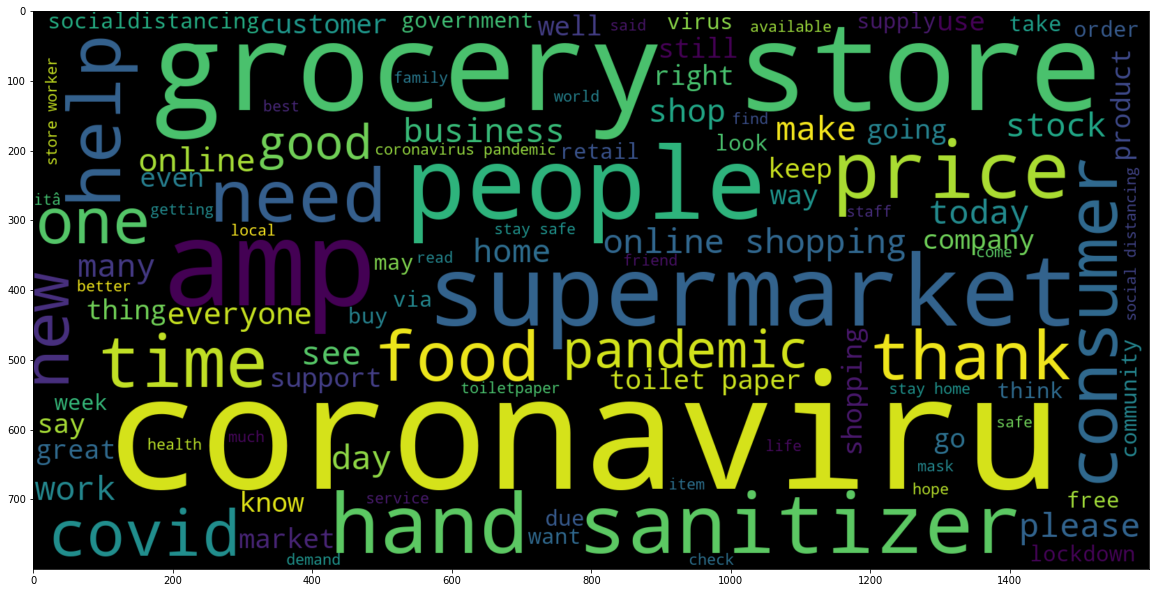

In [93]:
#Top 100 words for positive tweets:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 100 , width = 1600 , height = 800).generate(" ".join(train[(train.Sentiment == 'Positive') | (train.Sentiment == 'Extremely Positive')].OriginalTweet))
plt.imshow(wc , interpolation = 'bilinear')

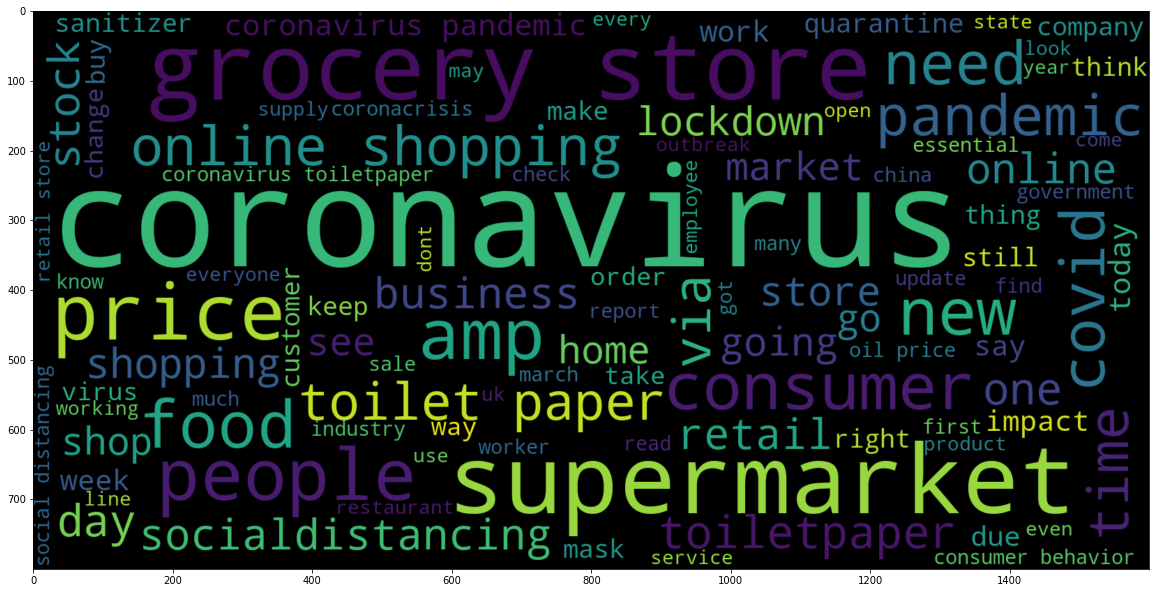

In [94]:
#Top 100 words for neutral tweets:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 100 , width = 1600 , height = 800).generate(" ".join(train[train.Sentiment == 'Neutral'].OriginalTweet))
plt.imshow(wc , interpolation = 'bilinear')

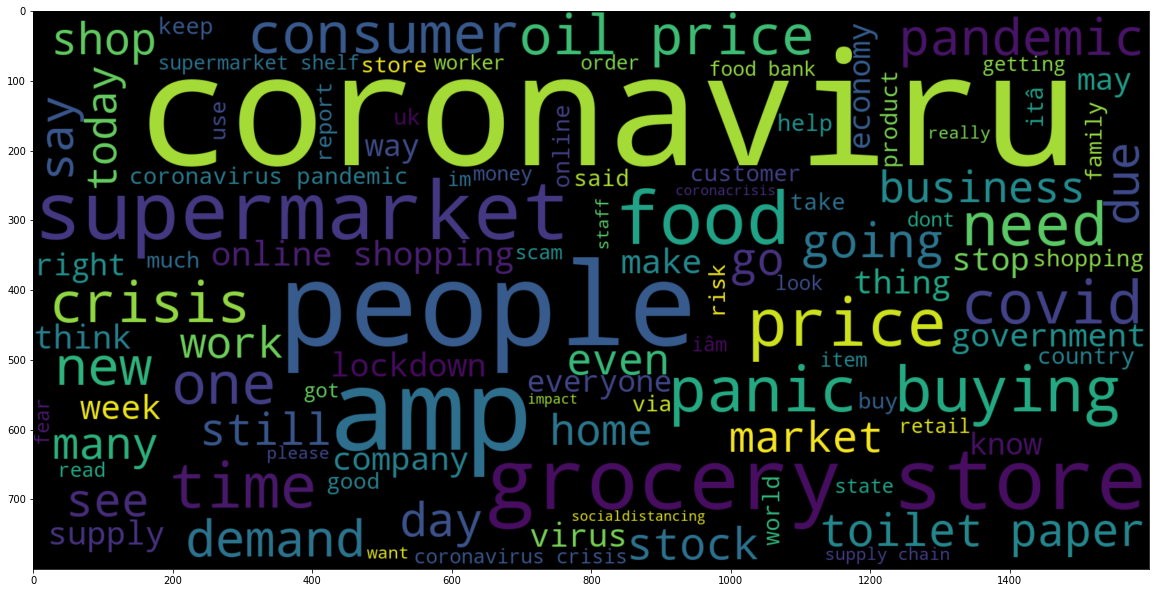

In [95]:
#Top 100 words for negative tweets:
plt.figure(figsize = (20,20)) # Text that is Fake
wc = WordCloud(max_words = 100 , width = 1600 , height = 800).generate(" ".join(train[(train.Sentiment == 'Negative') | (train.Sentiment == 'Extremely Negative')].OriginalTweet))
plt.imshow(wc , interpolation = 'bilinear')

It seems 👌, now let's go into the data preparation for our model:

In [96]:
train.to_csv('/Users/spavot/Documents/Perso/Text classification & Visualization/Data/train_cleaned.csv', index=False)
test.to_csv('/Users/spavot/Documents/Perso/Text classification & Visualization/Data/test_cleaned.csv', index=False)


In [97]:
#Encode the target:
y_train = pd.get_dummies(train.Sentiment).values
y_test = pd.get_dummies(test.Sentiment).values

# Modeling Deep Neural Network with Keras

## Count Vectorizer Models:

Prepare the data with CountVectorizer method:

In [98]:
vectorizer = CountVectorizer()
vectorizer.fit(train.OriginalTweet.values)

X_train = vectorizer.transform(train.OriginalTweet.values)
X_test = vectorizer.transform(test.OriginalTweet.values)

X_train = X_train.toarray()
X_test = X_test.toarray()

### Simple one layer model:

In [99]:
opti = Adam(lr = 0.01)

model_simple_count = Sequential()
model_simple_count.add(Dense(16, input_dim = X_train.shape[1], activation = 'relu'))
model_simple_count.add(Dense(3, activation = 'softmax'))

In [100]:
model_simple_count.compile(loss = 'categorical_crossentropy', optimizer = opti, metrics = ['accuracy'])
model_simple_count.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                840016    
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 51        
Total params: 840,067
Trainable params: 840,067
Non-trainable params: 0
_________________________________________________________________


In [101]:
history_simple_count = model_simple_count.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Train on 41134 samples, validate on 3798 samples
Epoch 1/10
41134/41134 [==============================] - 41s 999us/sample - loss: 0.6543 - accuracy: 0.7368 - val_loss: 0.5812 - val_accuracy: 0.7788
Epoch 2/10
41134/41134 [==============================] - 41s 996us/sample - loss: 0.3071 - accuracy: 0.8910 - val_loss: 0.6634 - val_accuracy: 0.7691
Epoch 3/10
41134/41134 [==============================] - 39s 943us/sample - loss: 0.1602 - accuracy: 0.9428 - val_loss: 0.8408 - val_accuracy: 0.7686
Epoch 4/10
41134/41134 [==============================] - 39s 949us/sample - loss: 0.0950 - accuracy: 0.9674 - val_loss: 1.0905 - val_accuracy: 0.7591
Epoch 5/10
41134/41134 [==============================] - 42s 1ms/sample - loss: 0.0622 - accuracy: 0.9786 - val_loss: 1.3109 - val_accuracy: 0.7559
Epoch 6/10
41134/41134 [==============================] - 41s 992us/sample - loss: 0.0460 - accuracy: 0.9832 - val_loss: 1.5760 - val_accuracy: 0.7470
Epoch 7/10
41134/41134 [=======================

In [102]:
#Save models and history
model_simple_count.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/NN_Models/Simple_model_Count.h5')
np.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/History/history_simple_count.npy',history_simple_count.history)

### Mutli layers models:

In [103]:
opti = Adam(lr = 0.01)

model_multi_count = Sequential()
model_multi_count.add(Dense(64, input_dim = X_train.shape[1], activation = 'relu'))
model_multi_count.add(Dense(32, activation = 'relu'))
model_multi_count.add(Dense(16, activation = 'relu'))
model_multi_count.add(Dense(3, activation = 'softmax'))

In [104]:
model_multi_count.compile(loss = 'categorical_crossentropy', optimizer = opti, metrics = ['accuracy'])
model_multi_count.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 64)                3360064   
_________________________________________________________________
dense_9 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 51        
Total params: 3,362,723
Trainable params: 3,362,723
Non-trainable params: 0
_________________________________________________________________


In [105]:
history_multi_count = model_multi_count.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Train on 41134 samples, validate on 3798 samples
Epoch 1/10
41134/41134 [==============================] - 88s 2ms/sample - loss: 0.6823 - accuracy: 0.7212 - val_loss: 0.5977 - val_accuracy: 0.7715
Epoch 2/10
41134/41134 [==============================] - 86s 2ms/sample - loss: 0.3595 - accuracy: 0.8738 - val_loss: 0.6022 - val_accuracy: 0.7765
Epoch 3/10
41134/41134 [==============================] - 86s 2ms/sample - loss: 0.2012 - accuracy: 0.9348 - val_loss: 0.7902 - val_accuracy: 0.7628
Epoch 4/10
41134/41134 [==============================] - 86s 2ms/sample - loss: 0.1225 - accuracy: 0.9629 - val_loss: 0.8951 - val_accuracy: 0.7628
Epoch 5/10
41134/41134 [==============================] - 87s 2ms/sample - loss: 0.0791 - accuracy: 0.9770 - val_loss: 1.0073 - val_accuracy: 0.7593
Epoch 6/10
41134/41134 [==============================] - 87s 2ms/sample - loss: 0.0572 - accuracy: 0.9832 - val_loss: 1.2783 - val_accuracy: 0.7388
Epoch 7/10
41134/41134 [==============================] -

In [106]:
#Save models and history
model_multi_count.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/NN_Models/model_multi_count.h5')
np.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/History/history_multi_count.npy',history_multi_count.history)

## Embedding models:

In [107]:
train['num_words'] = train.OriginalTweet.apply(lambda x : len(x.split()))
max(train['num_words'])

39

In [108]:
maxlen = 30

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train.OriginalTweet.values)

X_train = tokenizer.texts_to_sequences(train.OriginalTweet.values)
X_test = tokenizer.texts_to_sequences(test.OriginalTweet.values)

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

vocab_size = len(tokenizer.word_index) + 1

### Simple one layer Model:

In [109]:
embedding_dim = 30
opti = Adam(lr = 0.01)

model_simple_embed = Sequential()
model_simple_embed.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model_simple_embed.add(Flatten())
model_simple_embed.add(Dense(16, activation = 'relu'))
model_simple_embed.add(Dense(3, activation = 'softmax'))

In [110]:
model_simple_embed.compile(loss = 'categorical_crossentropy', optimizer = opti, metrics = ['accuracy'])
model_simple_embed.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 30)            1575780   
_________________________________________________________________
flatten_1 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 16)                14416     
_________________________________________________________________
dense_13 (Dense)             (None, 3)                 51        
Total params: 1,590,247
Trainable params: 1,590,247
Non-trainable params: 0
_________________________________________________________________


In [111]:
history_simple_embed = model_simple_embed.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Train on 41134 samples, validate on 3798 samples
Epoch 1/10
41134/41134 [==============================] - 43s 1ms/sample - loss: 0.7042 - accuracy: 0.7082 - val_loss: 0.6704 - val_accuracy: 0.7464
Epoch 2/10
41134/41134 [==============================] - 45s 1ms/sample - loss: 0.4440 - accuracy: 0.8359 - val_loss: 0.6898 - val_accuracy: 0.7496
Epoch 3/10
41134/41134 [==============================] - 55s 1ms/sample - loss: 0.2813 - accuracy: 0.9000 - val_loss: 1.0260 - val_accuracy: 0.7299
Epoch 4/10
41134/41134 [==============================] - 44s 1ms/sample - loss: 0.1869 - accuracy: 0.9330 - val_loss: 1.0243 - val_accuracy: 0.7322
Epoch 5/10
41134/41134 [==============================] - 47s 1ms/sample - loss: 0.1417 - accuracy: 0.9513 - val_loss: 1.2595 - val_accuracy: 0.7309
Epoch 6/10
41134/41134 [==============================] - 46s 1ms/sample - loss: 0.1204 - accuracy: 0.9603 - val_loss: 1.4724 - val_accuracy: 0.7098
Epoch 7/10
41134/41134 [==============================] -

In [112]:
#Save models and history
model_simple_embed.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/NN_Models/model_simple_embed.h5')
np.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/History/history_simple_embed.npy',history_simple_embed.history)

### Multi layers Model:

In [113]:
embedding_dim = 30
opti = Adam(lr = 0.01)

multi_model_Embed = Sequential()
multi_model_Embed.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
multi_model_Embed.add(Flatten())
multi_model_Embed.add(Dense(64, activation = 'relu'))
multi_model_Embed.add(Dense(32, activation = 'relu'))
multi_model_Embed.add(Dense(16, activation = 'relu'))
multi_model_Embed.add(Dense(3, activation = 'softmax'))

In [114]:
multi_model_Embed.compile(loss = 'categorical_crossentropy', optimizer = opti, metrics = ['accuracy'])
multi_model_Embed.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 30)            1575780   
_________________________________________________________________
flatten_2 (Flatten)          (None, 900)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                57664     
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_16 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_17 (Dense)             (None, 3)                 51        
Total params: 1,636,103
Trainable params: 1,636,103
Non-trainable params: 0
____________________________________________

In [115]:
history_multi_Embed = multi_model_Embed.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Train on 41134 samples, validate on 3798 samples
Epoch 1/10
41134/41134 [==============================] - 47s 1ms/sample - loss: 0.7127 - accuracy: 0.7025 - val_loss: 0.6222 - val_accuracy: 0.7683
Epoch 2/10
41134/41134 [==============================] - 45s 1ms/sample - loss: 0.4393 - accuracy: 0.8498 - val_loss: 0.5795 - val_accuracy: 0.7949
Epoch 3/10
41134/41134 [==============================] - 49s 1ms/sample - loss: 0.2929 - accuracy: 0.9057 - val_loss: 0.6530 - val_accuracy: 0.7857
Epoch 4/10
41134/41134 [==============================] - 56s 1ms/sample - loss: 0.2069 - accuracy: 0.9358 - val_loss: 0.8046 - val_accuracy: 0.7746
Epoch 5/10
41134/41134 [==============================] - 50s 1ms/sample - loss: 0.1626 - accuracy: 0.9494 - val_loss: 1.0496 - val_accuracy: 0.7646
Epoch 6/10
41134/41134 [==============================] - 51s 1ms/sample - loss: 0.1389 - accuracy: 0.9585 - val_loss: 0.9891 - val_accuracy: 0.7633
Epoch 7/10
41134/41134 [==============================] -

In [116]:
#Save models and history
multi_model_Embed.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/NN_Models/multi_model_Embed.h5')
np.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/History/history_multi_Embed.npy',history_multi_Embed.history)

## Glove Dictionnary Models:

Get the glove dictionnary and initiate it:

In [117]:
embeddings_index = {}
with open('/Users/spavot/Documents/Perso/Text classification & Visualization/Data/glove.6B/glove.6B.200d.txt') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [118]:
num_tokens = len(tokenizer.word_index) + 1
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 25072 words (27453 misses)


### Simple Glove model:

In [119]:
embedding_dim = 200
opti = Adam(lr=0.01)

model_simple_glove = Sequential()
model_simple_glove.add(Embedding(vocab_size, embedding_dim,input_length=maxlen, weights = [embedding_matrix], trainable = False))
model_simple_glove.add(Flatten())
model_simple_glove.add(Dense(16, activation = 'relu'))
model_simple_glove.add(Dense(3, activation = 'softmax'))

In [120]:
model_simple_glove.compile(loss = 'categorical_crossentropy', optimizer = opti, metrics = ['accuracy'])
model_simple_glove.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 200)           10505200  
_________________________________________________________________
flatten_3 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                96016     
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 51        
Total params: 10,601,267
Trainable params: 96,067
Non-trainable params: 10,505,200
_________________________________________________________________


In [121]:
history_simple_glove = model_simple_glove.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Train on 41134 samples, validate on 3798 samples
Epoch 1/10
41134/41134 [==============================] - 24s 576us/sample - loss: 0.8921 - accuracy: 0.5988 - val_loss: 0.8358 - val_accuracy: 0.6264
Epoch 2/10
41134/41134 [==============================] - 24s 575us/sample - loss: 0.8150 - accuracy: 0.6502 - val_loss: 0.8325 - val_accuracy: 0.6187
Epoch 3/10
41134/41134 [==============================] - 25s 604us/sample - loss: 0.7851 - accuracy: 0.6641 - val_loss: 0.8383 - val_accuracy: 0.6319
Epoch 4/10
41134/41134 [==============================] - 26s 621us/sample - loss: 0.7629 - accuracy: 0.6708 - val_loss: 0.8900 - val_accuracy: 0.6080
Epoch 5/10
41134/41134 [==============================] - 25s 598us/sample - loss: 0.7480 - accuracy: 0.6806 - val_loss: 0.9183 - val_accuracy: 0.5953
Epoch 6/10
41134/41134 [==============================] - 25s 604us/sample - loss: 0.7383 - accuracy: 0.6815 - val_loss: 0.8894 - val_accuracy: 0.5932
Epoch 7/10
41134/41134 [=====================

In [122]:
#Save models and history
model_simple_glove.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/NN_Models/model_simple_glove.h5')
np.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/History/history_simple_glove.npy',history_simple_glove.history)

### Mutli layers Glove model:

In [123]:
embedding_dim = 200
opti = Adam(lr = 0.01)

model_multi_glove = Sequential()
model_multi_glove.add(Embedding(vocab_size, embedding_dim,input_length=maxlen, weights = [embedding_matrix], trainable = False))
model_multi_glove.add(Flatten())
model_multi_glove.add(Dense(64, activation = 'relu'))
model_multi_glove.add(Dense(32, activation = 'relu'))
model_multi_glove.add(Dense(16, activation = 'relu'))
model_multi_glove.add(Dense(3, activation = 'softmax'))

In [124]:
model_multi_glove.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_multi_glove.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 30, 200)           10505200  
_________________________________________________________________
flatten_4 (Flatten)          (None, 6000)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                384064    
_________________________________________________________________
dense_21 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_22 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 51        
Total params: 10,891,923
Trainable params: 386,723
Non-trainable params: 10,505,200
____________________________________

In [125]:
history_Multi_glove = model_multi_glove.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Train on 41134 samples, validate on 3798 samples
Epoch 1/10
41134/41134 [==============================] - 30s 724us/sample - loss: 0.8418 - accuracy: 0.6162 - val_loss: 0.7894 - val_accuracy: 0.6464
Epoch 2/10
41134/41134 [==============================] - 30s 717us/sample - loss: 0.7225 - accuracy: 0.6865 - val_loss: 0.7970 - val_accuracy: 0.6406
Epoch 3/10
41134/41134 [==============================] - 29s 716us/sample - loss: 0.6167 - accuracy: 0.7382 - val_loss: 0.8404 - val_accuracy: 0.6290
Epoch 4/10
41134/41134 [==============================] - 30s 738us/sample - loss: 0.4847 - accuracy: 0.8034 - val_loss: 0.9887 - val_accuracy: 0.6069
Epoch 5/10
41134/41134 [==============================] - 29s 709us/sample - loss: 0.3561 - accuracy: 0.8585 - val_loss: 1.1460 - val_accuracy: 0.6161
Epoch 6/10
41134/41134 [==============================] - 29s 716us/sample - loss: 0.2611 - accuracy: 0.8985 - val_loss: 1.4842 - val_accuracy: 0.5990
Epoch 7/10
41134/41134 [=====================

In [126]:
#Save models and history
model_multi_glove.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/NN_Models/model_multi_glove.h5')
np.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/History/history_Multi_glove.npy',history_Multi_glove.history)

## Convolutional Neural Networks:

In [45]:
embedding_dim = 30
opti = Adam(lr=0.01)

model_Conv = Sequential()
model_Conv.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model_Conv.add(Dropout(0.2))
model_Conv.add(Conv1D(16, 3, activation='relu'))
model_Conv.add(GlobalMaxPool1D())
model_Conv.add(Dense(3, activation = 'softmax'))

In [46]:
model_Conv.compile(loss = 'categorical_crossentropy', optimizer = opti, metrics = ['accuracy'])
model_Conv.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 30)            1575780   
_________________________________________________________________
dropout (Dropout)            (None, 30, 30)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 28, 16)            1456      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 51        
Total params: 1,577,287
Trainable params: 1,577,287
Non-trainable params: 0
_________________________________________________________________


In [47]:
history_Conv = model_Conv.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Train on 41134 samples, validate on 3798 samples
Epoch 1/10
41134/41134 [==============================] - 51s 1ms/sample - loss: 0.6478 - accuracy: 0.7480 - val_loss: 0.5548 - val_accuracy: 0.7978
Epoch 2/10
41134/41134 [==============================] - 51s 1ms/sample - loss: 0.4811 - accuracy: 0.8340 - val_loss: 0.5413 - val_accuracy: 0.7991
Epoch 3/10
41134/41134 [==============================] - 52s 1ms/sample - loss: 0.4066 - accuracy: 0.8644 - val_loss: 0.5267 - val_accuracy: 0.8091
Epoch 4/10
41134/41134 [==============================] - 52s 1ms/sample - loss: 0.3635 - accuracy: 0.8781 - val_loss: 0.6092 - val_accuracy: 0.7944
Epoch 5/10
41134/41134 [==============================] - 48s 1ms/sample - loss: 0.3237 - accuracy: 0.8940 - val_loss: 0.6756 - val_accuracy: 0.7957
Epoch 6/10
41134/41134 [==============================] - 48s 1ms/sample - loss: 0.2914 - accuracy: 0.9041 - val_loss: 0.6117 - val_accuracy: 0.7970
Epoch 7/10
41134/41134 [==============================] -

In [127]:
model_Conv.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/NN_Models/model_Conv.h5')
np.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/History/history_Conv.npy',history_Conv.history)

### Convolutional with Glove dictionnary:

In [49]:
embedding_dim = 200
opti = Adam(lr=0.01)

model_Conv_glove = Sequential()
model_Conv_glove.add(Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim,
                           weights = [embedding_matrix],
                           input_length=maxlen))
model_Conv_glove.add(Dropout(0.2))
model_Conv_glove.add(Conv1D(16, 3, activation='relu'))
model_Conv_glove.add(GlobalMaxPool1D())
model_Conv_glove.add(Dense(3, activation = 'softmax'))

In [50]:
model_Conv_glove.compile(loss = 'categorical_crossentropy', optimizer = opti, metrics = ['accuracy'])
model_Conv_glove.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 200)           10505200  
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 28, 16)            9616      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 51        
Total params: 10,514,867
Trainable params: 10,514,867
Non-trainable params: 0
_________________________________________________________________


In [51]:
history_Conv_glove = model_Conv_glove.fit(X_train, y_train,
                    epochs=10,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)

Train on 41134 samples, validate on 3798 samples
Epoch 1/10
41134/41134 [==============================] - 255s 6ms/sample - loss: 0.6514 - accuracy: 0.7550 - val_loss: 0.5897 - val_accuracy: 0.7809
Epoch 2/10
41134/41134 [==============================] - 225s 5ms/sample - loss: 0.5139 - accuracy: 0.8276 - val_loss: 0.6047 - val_accuracy: 0.7812
Epoch 3/10
41134/41134 [==============================] - 223s 5ms/sample - loss: 0.4597 - accuracy: 0.8520 - val_loss: 0.6472 - val_accuracy: 0.7801
Epoch 4/10
41134/41134 [==============================] - 222s 5ms/sample - loss: 0.4224 - accuracy: 0.8671 - val_loss: 0.6731 - val_accuracy: 0.7757
Epoch 5/10
41134/41134 [==============================] - 222s 5ms/sample - loss: 0.3924 - accuracy: 0.8789 - val_loss: 0.7838 - val_accuracy: 0.7670
Epoch 6/10
41134/41134 [==============================] - 221s 5ms/sample - loss: 0.3769 - accuracy: 0.8867 - val_loss: 0.9589 - val_accuracy: 0.7757
Epoch 7/10
41134/41134 [===========================

In [56]:
model_Conv_glove.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/NN_Models/model_Conv_glove.h5')
np.save('/Users/spavot/Documents/Perso/Text classification & Visualization/Models/History/history_Conv_glove.npy',history_Conv_glove.history)

Let's now build a streamlit app to see interactively the results of our models and play with it.